<a href="https://colab.research.google.com/github/divyanshuraj6815/EVA6/blob/main/Experiment_4/experiment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #input 28 x 28 x 1
        #ouput 26 x 26 x 16
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.bn1 = nn.BatchNorm2d (16)
        
        #input 26 x 26 x 16
        #ouput 24 x 24 x 32
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.bn2 = nn.BatchNorm2d (32)
        self.do1 = nn.Dropout2d (0.1)

        #reduce the channel size
        #input 24 x 24 x 32
        #ouput 24 x 24 x 10
        self.red = nn.Conv2d(32, 10, 1)

        #input 24 x 24 x 10
        #ouput 12 x 12 x 10
        self.pool1 = nn.MaxPool2d(2, 2)

        #input 12 x 12 x 10
        #ouput 10 x 10 x 16
        self.conv3 = nn.Conv2d(10, 16, 3)
        self.bn3 = nn.BatchNorm2d (16)
        
        #input 10 x 10 x 16
        #ouput  8 x  8 x 16
        self.conv4 = nn.Conv2d(16, 16, 3)
        self.bn4 = nn.BatchNorm2d (16)
        self.do2 = nn.Dropout2d (0.1)
        
        #input 8 x 8 x 16
        #ouput 6 x 6 x 16
        self.conv5 = nn.Conv2d(16, 16, 3)
        self.bn5 = nn.BatchNorm2d (16)
        self.do3 = nn.Dropout2d (0.069)

        #input 6 x 6 x 16
        #ouput 4 x 4 x 32
        self.conv6 = nn.Conv2d(16, 32, 3)
        self.bn6 = nn.BatchNorm2d (32)

        #input 4 x 4 x 32
        #ouput 1 x 1 x 32
        self.gap = nn.AvgPool2d (4)

        #input 1 x 32
        #ouput 1 x 10
        self.fc = nn.Linear (32, 10)
        
    def forward(self, x):
        #block 1
        x = self.bn1(F.relu(self.conv1(x)))
        #block 2
        x = self.bn2(F.relu(self.conv2(x)))

        #reduce channel
        x = self.red(x)

        #maxpool
        x = self.do1(self.pool1(x))
        
        #block 3
        x = self.bn3(F.relu(self.conv3(x)))
        #block 4
        x = self.do2(self.bn4(F.relu(self.conv4(x))))
        #block 5
        x = self.do3(self.bn5(F.relu(self.conv5(x))))
        #block 6
        x = self.bn6(F.relu(self.conv6(x)))

        #global average pooling
        x = self.gap(x)

        #reducing the dimension
        x = x.view(-1, 32)

        #fully connected layer
        x = self.fc (x)

        return F.log_softmax(x)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
            Conv2d-3           [-1, 32, 24, 24]           4,640
       BatchNorm2d-4           [-1, 32, 24, 24]              64
            Conv2d-5           [-1, 10, 24, 24]             330
         MaxPool2d-6           [-1, 10, 12, 12]               0
         Dropout2d-7           [-1, 10, 12, 12]               0
            Conv2d-8           [-1, 16, 10, 10]           1,456
       BatchNorm2d-9           [-1, 16, 10, 10]              32
           Conv2d-10             [-1, 16, 8, 8]           2,320
      BatchNorm2d-11             [-1, 16, 8, 8]              32
        Dropout2d-12             [-1, 16, 8, 8]               0
           Conv2d-13             [-1, 16, 6, 6]           2,320
      BatchNorm2d-14             [-1, 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [9]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                        transforms.RandomRotation (5)
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


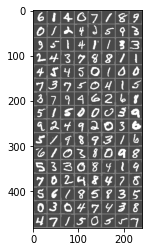

    6     1     4     0


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# functions to show an image
def imshow (img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy ()
    plt.imshow (np.transpose (npimg, (1, 2, 0)))
    plt.show ()

# get some random training images
dataiter = iter (train_loader)
images, labels = dataiter.next ()

# show images
imshow (torchvision.utils.make_grid (images))
# print labels
print(' '.join ('%5s' % classes[labels[j]] for j in range (4)))

In [11]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    total_loss = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        total_loss += loss
        pbar.set_description(desc= f'epoch={epoch} batch_id={batch_idx} correct={correct}/{(batch_idx + 1) * 128} loss={loss.item()}')

    graph['train_loss'].append (total_loss / len(train_loader.dataset))
    graph['train_acc'].append (correct * 100. / len(train_loader.dataset))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    graph['test_loss'].append (test_loss)
    graph['test_acc'].append (correct * 100. / len (test_loader.dataset))

In [12]:
model = Net().to(device)
graph = {
    'train_loss' : [],
    'train_acc' : [],
    'test_loss' : [],
    'test_acc' : []
}
optimizer = optim.Adam (model.parameters (), lr = 0.003)
for epoch in range(1, 20):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
epoch=1 batch_id=468 correct=56440/60032 loss=0.07352112233638763: 100%|██████████| 469/469 [00:33<00:00, 14.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9871/10000 (98.7%)



epoch=2 batch_id=468 correct=58808/60032 loss=0.08499928563833237: 100%|██████████| 469/469 [00:32<00:00, 14.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9883/10000 (98.8%)



epoch=3 batch_id=468 correct=58956/60032 loss=0.0748157650232315: 100%|██████████| 469/469 [00:33<00:00, 14.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9913/10000 (99.1%)



epoch=4 batch_id=468 correct=59099/60032 loss=0.05044831335544586: 100%|██████████| 469/469 [00:33<00:00, 14.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9887/10000 (98.9%)



epoch=5 batch_id=468 correct=59187/60032 loss=0.01086775865405798: 100%|██████████| 469/469 [00:33<00:00, 14.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9921/10000 (99.2%)



epoch=6 batch_id=468 correct=59222/60032 loss=0.029052408412098885: 100%|██████████| 469/469 [00:33<00:00, 14.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9931/10000 (99.3%)



epoch=7 batch_id=468 correct=59287/60032 loss=0.01651386357843876: 100%|██████████| 469/469 [00:33<00:00, 14.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9899/10000 (99.0%)



epoch=8 batch_id=468 correct=59353/60032 loss=0.010828404687345028: 100%|██████████| 469/469 [00:33<00:00, 14.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9934/10000 (99.3%)



epoch=9 batch_id=468 correct=59317/60032 loss=0.0741238221526146: 100%|██████████| 469/469 [00:32<00:00, 14.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9934/10000 (99.3%)



epoch=10 batch_id=468 correct=59360/60032 loss=0.008972225710749626: 100%|██████████| 469/469 [00:33<00:00, 14.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9929/10000 (99.3%)



epoch=11 batch_id=468 correct=59419/60032 loss=0.08837265521287918: 100%|██████████| 469/469 [00:33<00:00, 14.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9928/10000 (99.3%)



epoch=12 batch_id=468 correct=59417/60032 loss=0.04492028430104256: 100%|██████████| 469/469 [00:33<00:00, 14.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9945/10000 (99.5%)



epoch=13 batch_id=468 correct=59431/60032 loss=0.00836543831974268: 100%|██████████| 469/469 [00:33<00:00, 14.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9943/10000 (99.4%)



epoch=14 batch_id=468 correct=59470/60032 loss=0.0052503678016364574: 100%|██████████| 469/469 [00:33<00:00, 13.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9935/10000 (99.3%)



epoch=15 batch_id=468 correct=59444/60032 loss=0.05461813881993294: 100%|██████████| 469/469 [00:33<00:00, 14.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9943/10000 (99.4%)



epoch=16 batch_id=468 correct=59512/60032 loss=0.022876618430018425: 100%|██████████| 469/469 [00:33<00:00, 14.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.4%)



epoch=17 batch_id=468 correct=59496/60032 loss=0.15549825131893158: 100%|██████████| 469/469 [00:33<00:00, 14.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9939/10000 (99.4%)



epoch=18 batch_id=468 correct=59465/60032 loss=0.01704123057425022: 100%|██████████| 469/469 [00:33<00:00, 14.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9934/10000 (99.3%)



epoch=19 batch_id=468 correct=59558/60032 loss=0.0049037323333323: 100%|██████████| 469/469 [00:33<00:00, 13.99it/s]



Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99.3%)



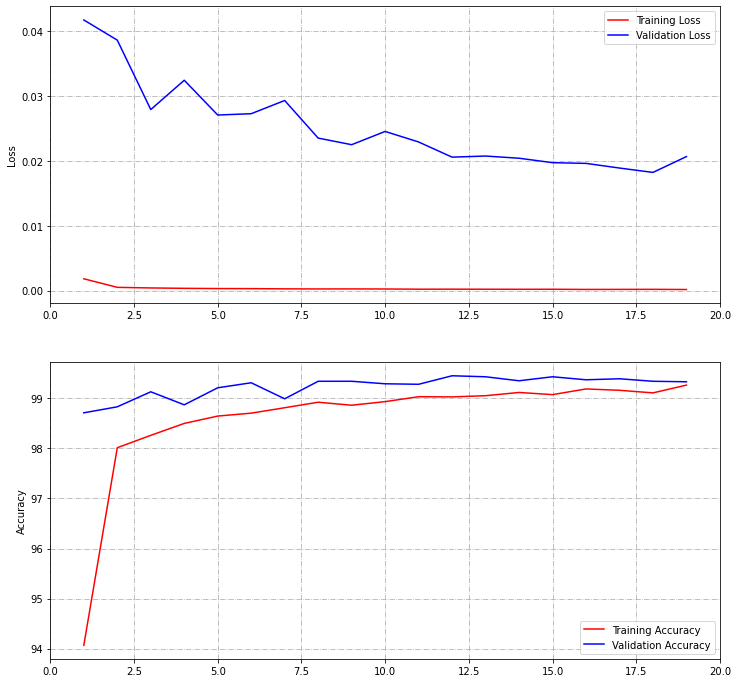

In [13]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
ax = plt.gca()
e = 18
ax.set_xlim([0, e + 2])
plt.ylabel('Loss')
plt.plot(range(1, e + 2), graph['train_loss'][:e+1], 'r', label='Training Loss')
plt.plot(range(1, e + 2), graph['test_loss'][:e+1], 'b', label='Validation Loss')
ax.grid(linestyle='-.')
plt.legend()
plt.subplot(2,1,2)
ax = plt.gca()
ax.set_xlim([0, e+2])
plt.ylabel('Accuracy')
plt.plot(range(1, e + 2), graph['train_acc'][:e+1], 'r', label='Training Accuracy')
plt.plot(range(1, e + 2), graph['test_acc'][:e+1], 'b', label='Validation Accuracy')
ax.grid(linestyle='-.')
plt.legend()
plt.show()

In [14]:
model = Net().to(device)
graph = {
    'train_loss' : [],
    'train_acc' : [],
    'test_loss' : [],
    'test_acc' : []
}
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
for epoch in range(1, 20):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
epoch=1 batch_id=468 correct=54616/60032 loss=0.1920093148946762: 100%|██████████| 469/469 [00:32<00:00, 14.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9885/10000 (98.8%)



epoch=2 batch_id=468 correct=58671/60032 loss=0.04189980402588844: 100%|██████████| 469/469 [00:32<00:00, 14.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9895/10000 (99.0%)



epoch=3 batch_id=468 correct=58910/60032 loss=0.025722526013851166: 100%|██████████| 469/469 [00:33<00:00, 14.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9912/10000 (99.1%)



epoch=4 batch_id=468 correct=59023/60032 loss=0.04859260097146034: 100%|██████████| 469/469 [00:33<00:00, 14.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9914/10000 (99.1%)



epoch=5 batch_id=468 correct=59132/60032 loss=0.019235964864492416: 100%|██████████| 469/469 [00:33<00:00, 14.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9928/10000 (99.3%)



epoch=6 batch_id=468 correct=59202/60032 loss=0.05548763647675514: 100%|██████████| 469/469 [00:33<00:00, 14.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9938/10000 (99.4%)



epoch=7 batch_id=468 correct=59235/60032 loss=0.01771123707294464: 100%|██████████| 469/469 [00:33<00:00, 14.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9944/10000 (99.4%)



epoch=8 batch_id=468 correct=59310/60032 loss=0.006635576020926237: 100%|██████████| 469/469 [00:32<00:00, 14.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9928/10000 (99.3%)



epoch=9 batch_id=468 correct=59340/60032 loss=0.011683888733386993: 100%|██████████| 469/469 [00:33<00:00, 14.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9941/10000 (99.4%)



epoch=10 batch_id=468 correct=59403/60032 loss=0.022732296958565712: 100%|██████████| 469/469 [00:33<00:00, 13.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9939/10000 (99.4%)



epoch=11 batch_id=468 correct=59387/60032 loss=0.0627293661236763: 100%|██████████| 469/469 [00:33<00:00, 14.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9933/10000 (99.3%)



epoch=12 batch_id=468 correct=59387/60032 loss=0.05924595892429352: 100%|██████████| 469/469 [00:33<00:00, 13.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9944/10000 (99.4%)



epoch=13 batch_id=468 correct=59444/60032 loss=0.01367159653455019: 100%|██████████| 469/469 [00:33<00:00, 13.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9931/10000 (99.3%)



epoch=14 batch_id=468 correct=59409/60032 loss=0.03672423213720322: 100%|██████████| 469/469 [00:33<00:00, 13.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9947/10000 (99.5%)



epoch=15 batch_id=468 correct=59441/60032 loss=0.009757526218891144: 100%|██████████| 469/469 [00:33<00:00, 13.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9937/10000 (99.4%)



epoch=16 batch_id=468 correct=59486/60032 loss=0.0392165444791317: 100%|██████████| 469/469 [00:33<00:00, 13.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9942/10000 (99.4%)



epoch=17 batch_id=468 correct=59489/60032 loss=0.036073848605155945: 100%|██████████| 469/469 [00:33<00:00, 14.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9950/10000 (99.5%)



epoch=18 batch_id=468 correct=59507/60032 loss=0.04765478894114494: 100%|██████████| 469/469 [00:33<00:00, 13.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9948/10000 (99.5%)



epoch=19 batch_id=468 correct=59514/60032 loss=0.012821383774280548: 100%|██████████| 469/469 [00:33<00:00, 13.97it/s]



Test set: Average loss: 0.0169, Accuracy: 9949/10000 (99.5%)



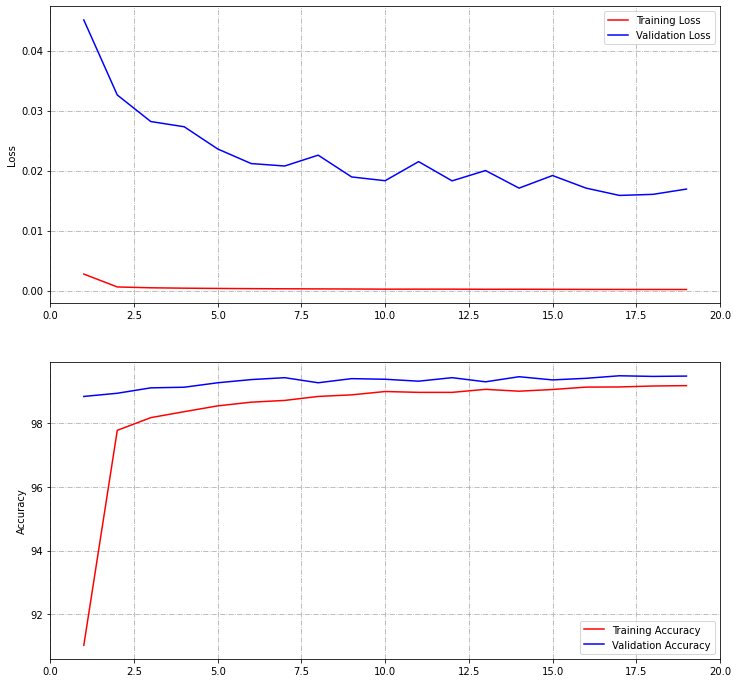

In [18]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
ax = plt.gca()
e = 18
ax.set_xlim([0, e + 2])
plt.ylabel('Loss')
plt.plot(range(1, e + 2), graph['train_loss'][:e+1], 'r', label='Training Loss')
plt.plot(range(1, e + 2), graph['test_loss'][:e+1], 'b', label='Validation Loss')
ax.grid(linestyle='-.')
plt.legend()
plt.subplot(2,1,2)
ax = plt.gca()
ax.set_xlim([0, e+2])
plt.ylabel('Accuracy')
plt.plot(range(1, e + 2), graph['train_acc'][:e+1], 'r', label='Training Accuracy')
plt.plot(range(1, e + 2), graph['test_acc'][:e+1], 'b', label='Validation Accuracy')
ax.grid(linestyle='-.')
plt.legend()
plt.show()

In [19]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Predicted Digit = 6
Predicted Digit = 2
Predicted Digit = 5
Predicted Digit = 7
Predicted Digit = 9
Predicted Digit = 1
Predicted Digit = 5
Predicted Digit = 4
Predicted Digit = 8


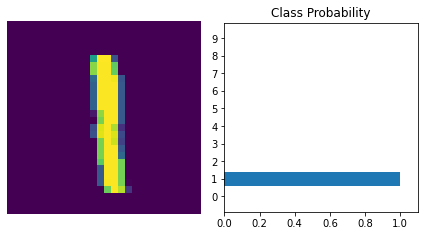

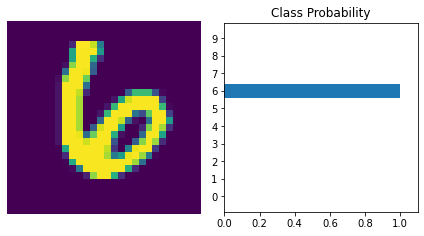

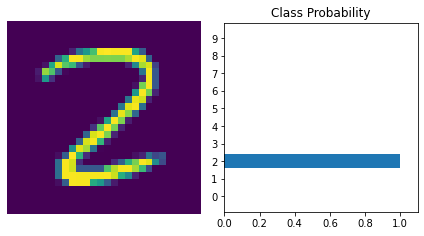

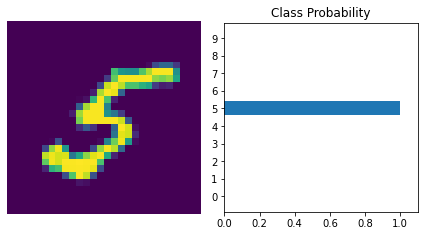

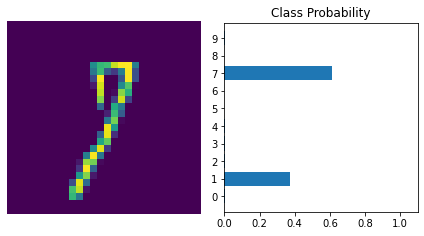

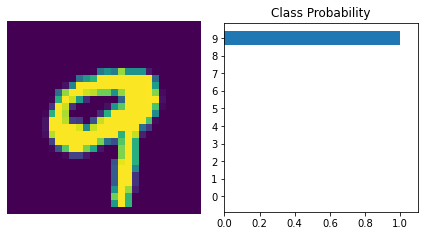

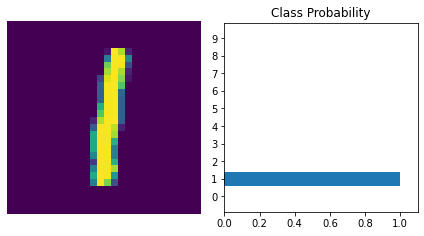

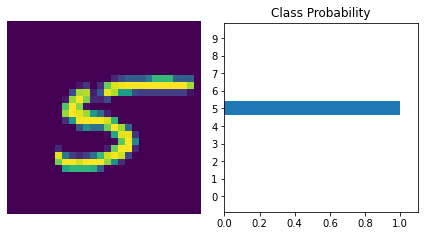

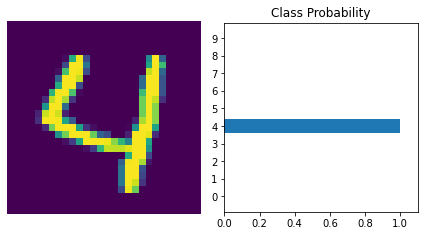

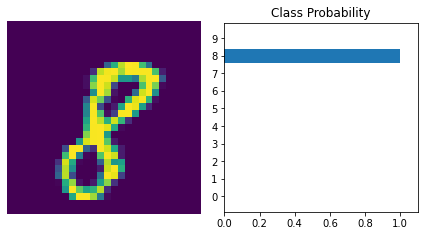

In [23]:
for i in range (10):
  images, labels = next (iter (test_loader))

  img = images
  # Turn off gradients to speed up this part
  with torch.no_grad():
      logps = model (img.cuda())

  # Output of the network are log-probabilities, need to take exponential for probabilities
  ps = torch.exp (logps)
  probab = list (ps.cpu().numpy()[0])
  print ("Predicted Digit =", probab.index (max (probab)))
  view_classify (img[0], ps[0])